# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier" / "_within_distance" / "gls-1000g_mashr-sub_corr"
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.009063,0.009463,-0.957713,0.338243,0.830878,random.pheno988
1,LV2,0.023012,0.012231,1.881436,0.059958,0.029979,random.pheno988
2,LV3,-0.014460,0.012069,-1.198117,0.230915,0.884542,random.pheno988
3,LV4,-0.016879,0.011593,-1.455957,0.145453,0.927273,random.pheno988
4,LV5,0.004201,0.012627,0.332689,0.739380,0.369690,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.08375177304964539

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.006,0.030,0.069
1,LV10,0.009,0.052,0.082
2,LV100,0.000,0.000,0.000
3,LV101,0.005,0.040,0.076
4,LV102,0.016,0.058,0.104


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.047812,0.083752,0.121566
std,0.112386,0.114137,0.114696
min,0.000000,0.000000,0.000000
25%,0.007500,0.038000,0.076000
50%,0.014000,0.055000,0.102000
75%,0.021000,0.071000,0.126000
max,0.598000,0.601000,0.601000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(51, 4)

,lv,1,5,10
166,LV249,0.010,0.049,0.079
288,LV359,0.010,0.049,0.085
842,LV858,0.013,0.049,0.086
222,LV3,0.012,0.049,0.100
530,LV577,0.012,0.049,0.096
181,LV262,0.015,0.049,0.102
171,LV253,0.011,0.049,0.089
315,LV383,0.012,0.049,0.104
761,LV785,0.012,0.049,0.086
363,LV426,0.015,0.049,0.097


,lv,1,5,10
40,LV135,0.008,0.050,0.093
438,LV494,0.015,0.050,0.096
729,LV756,0.024,0.050,0.090
819,LV837,0.012,0.051,0.094
816,LV834,0.012,0.051,0.095
810,LV829,0.010,0.051,0.098
856,LV870,0.016,0.051,0.101
17,LV114,0.016,0.051,0.097
541,LV587,0.012,0.051,0.092
514,LV562,0.007,0.051,0.096


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(397, 4)

,lv,1,5,10
939,LV945,0.434,0.458,0.467
381,LV442,0.452,0.466,0.475
979,LV981,0.454,0.468,0.477
637,LV673,0.455,0.470,0.480
711,LV74,0.472,0.474,0.479
924,LV931,0.472,0.483,0.491
463,LV516,0.508,0.548,0.559
342,LV407,0.587,0.593,0.601
710,LV739,0.591,0.596,0.598
234,LV31,0.594,0.597,0.598


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.011275,0.011612,0.970955,0.331607,0.165804,random.pheno988
1031,LV45,0.012786,0.011618,1.100587,0.271117,0.135559,random.pheno589
2018,LV45,0.008734,0.011616,0.751901,0.452138,0.226069,random.pheno385
3005,LV45,0.005584,0.011605,0.481166,0.630415,0.315207,random.pheno5
3992,LV45,-0.017823,0.011601,-1.536273,0.124521,0.937740,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.022

In [31]:
show_prop(results, 0.05)

0.067

In [32]:
show_prop(results, 0.10)

0.109

In [33]:
show_prop(results, 0.15)

0.151

In [34]:
show_prop(results, 0.20)

0.214

### QQplot

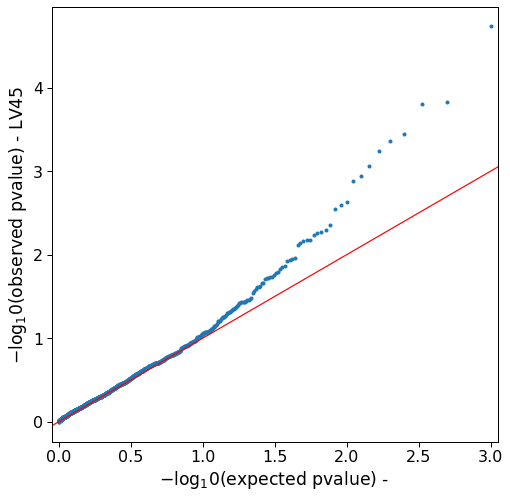

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,3.711328e-06,0.000222,0.016753,0.986634,0.493317,random.pheno988
1220,LV234,-4.268770e-08,0.000221,-0.000193,0.999846,0.500077,random.pheno589
2207,LV234,-3.543327e-06,0.000221,-0.016012,0.987225,0.506388,random.pheno385
3194,LV234,2.656094e-06,0.000221,0.012006,0.990422,0.495211,random.pheno5
4181,LV234,1.648014e-06,0.000222,0.007433,0.994069,0.497035,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.0

In [42]:
show_prop(results, 0.05)

0.0

In [43]:
show_prop(results, 0.10)

0.0

In [44]:
show_prop(results, 0.15)

0.0

In [45]:
show_prop(results, 0.20)

0.0

### QQplot

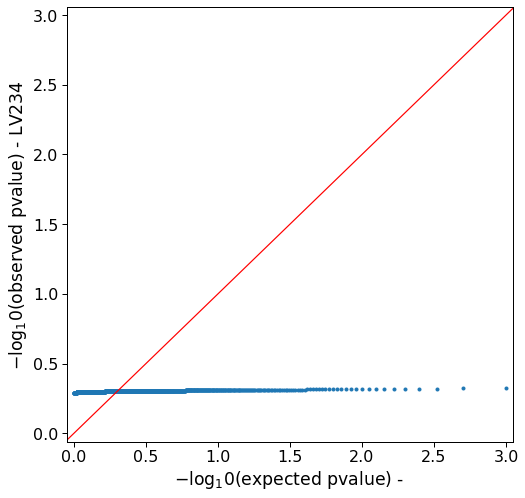

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.006114,0.013173,0.464141,0.642563,0.321281,random.pheno988
1833,LV847,0.003359,0.013197,0.254537,0.799089,0.399544,random.pheno589
2820,LV847,-0.014957,0.013180,-1.134860,0.256476,0.871762,random.pheno385
3807,LV847,0.006996,0.013162,0.531541,0.595062,0.297531,random.pheno5
4794,LV847,0.008845,0.013215,0.669328,0.503310,0.251655,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.028

In [53]:
show_prop(results, 0.05)

0.058

In [54]:
show_prop(results, 0.10)

0.109

In [55]:
show_prop(results, 0.15)

0.143

In [56]:
show_prop(results, 0.20)

0.187

### QQplot

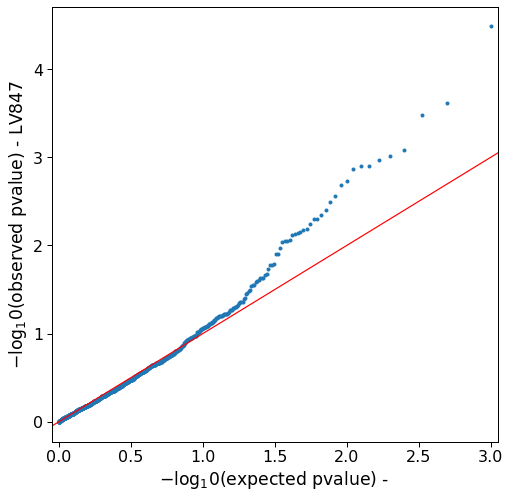

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.020465,0.013545,-1.510839,0.130879,0.934561,random.pheno988
1096,LV110,-0.006538,0.013540,-0.482831,0.629232,0.685384,random.pheno589
2083,LV110,-0.022428,0.013535,-1.657055,0.097557,0.951222,random.pheno385
3070,LV110,-0.009912,0.013494,-0.734545,0.462643,0.768678,random.pheno5
4057,LV110,-0.001046,0.013539,-0.077239,0.938436,0.530782,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.011

In [64]:
show_prop(results, 0.05)

0.037

In [65]:
show_prop(results, 0.10)

0.066

In [66]:
show_prop(results, 0.15)

0.116

In [67]:
show_prop(results, 0.20)

0.151

### QQplot

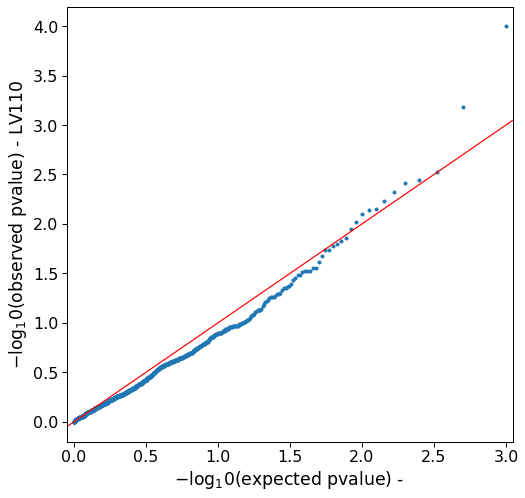

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014629,0.011747,1.245332,0.213055,0.106528,random.pheno988
1755,LV769,0.000931,0.011722,0.079443,0.936683,0.468341,random.pheno589
2742,LV769,0.001754,0.011724,0.149599,0.881086,0.440543,random.pheno385
3729,LV769,-0.014831,0.011730,-1.264416,0.206126,0.896937,random.pheno5
4716,LV769,-0.019155,0.011749,-1.630448,0.103056,0.948472,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.049

In [75]:
show_prop(results, 0.05)

0.136

In [76]:
show_prop(results, 0.10)

0.225

In [77]:
show_prop(results, 0.15)

0.291

In [78]:
show_prop(results, 0.20)

0.339

### QQplot

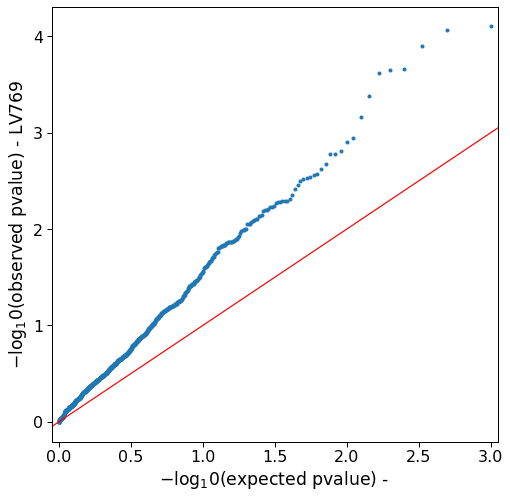

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.007137,0.013780,0.517955,0.604507,0.302254,random.pheno988
1786,LV800,-0.007699,0.013780,-0.558732,0.576364,0.711818,random.pheno589
2773,LV800,-0.001694,0.013797,-0.122758,0.902302,0.548849,random.pheno385
3760,LV800,-0.018497,0.013805,-1.339875,0.180333,0.909833,random.pheno5
4747,LV800,-0.010240,0.013754,-0.744511,0.456595,0.771703,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.012

In [86]:
show_prop(results, 0.05)

0.055

In [87]:
show_prop(results, 0.10)

0.101

In [88]:
show_prop(results, 0.15)

0.143

In [89]:
show_prop(results, 0.20)

0.192

### QQplot

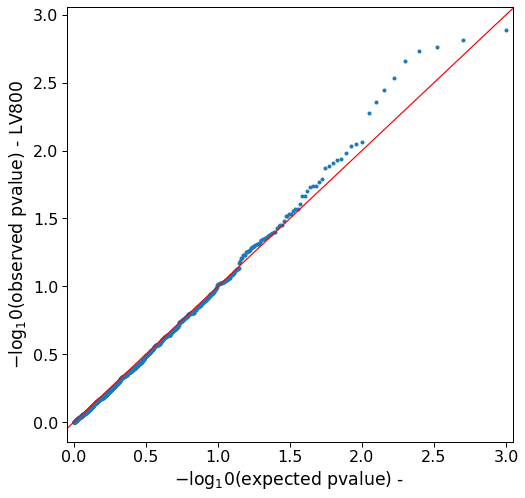

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
166,LV249,0.010,0.049,0.079
288,LV359,0.010,0.049,0.085
842,LV858,0.013,0.049,0.086
222,LV3,0.012,0.049,0.100
530,LV577,0.012,0.049,0.096
181,LV262,0.015,0.049,0.102
171,LV253,0.011,0.049,0.089
315,LV383,0.012,0.049,0.104
761,LV785,0.012,0.049,0.086
363,LV426,0.015,0.049,0.097


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.000591,0.001675,0.352624,0.724382,0.362191,random.pheno988
1398,LV412,0.000267,0.001666,0.160588,0.872423,0.436211,random.pheno589
2385,LV412,-0.000693,0.001666,-0.416379,0.677146,0.661427,random.pheno385
3372,LV412,0.000382,0.001675,0.228319,0.819406,0.409703,random.pheno5
4359,LV412,0.000372,0.001666,0.223334,0.823283,0.411641,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.0

In [99]:
show_prop(results, 0.05)

0.0

In [100]:
show_prop(results, 0.10)

0.0

In [101]:
show_prop(results, 0.15)

0.0

In [102]:
show_prop(results, 0.20)

0.004

### QQplot

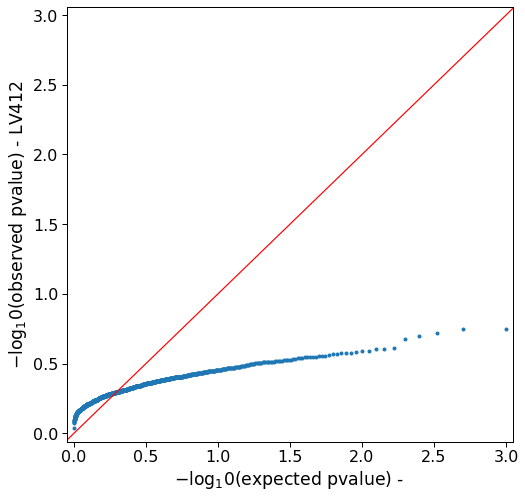

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020686,0.012286,-1.683648,0.092298,0.953851,random.pheno988
1043,LV57,0.017495,0.012291,1.423393,0.154671,0.077335,random.pheno589
2030,LV57,0.017966,0.012294,1.461396,0.143955,0.071978,random.pheno385
3017,LV57,-0.000373,0.012281,-0.030347,0.975791,0.512104,random.pheno5
4004,LV57,0.012608,0.012249,1.029300,0.303377,0.151689,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.008

In [110]:
show_prop(results, 0.05)

0.05

In [111]:
show_prop(results, 0.10)

0.101

In [112]:
show_prop(results, 0.15)

0.141

In [113]:
show_prop(results, 0.20)

0.178

### QQplot

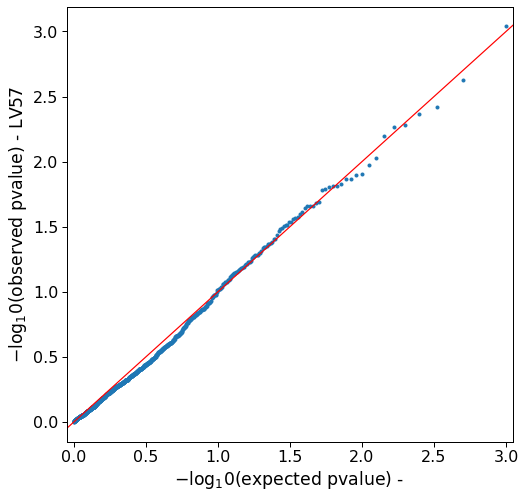

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.006784,0.012062,-0.562446,0.573832,0.713084,random.pheno988
1633,LV647,0.002681,0.012052,0.222486,0.823942,0.411971,random.pheno589
2620,LV647,0.003473,0.012067,0.287799,0.773510,0.386755,random.pheno385
3607,LV647,0.003691,0.012071,0.305801,0.759766,0.379883,random.pheno5
4594,LV647,0.001975,0.012024,0.164289,0.869509,0.434754,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.005

In [121]:
show_prop(results, 0.05)

0.034

In [122]:
show_prop(results, 0.10)

0.069

In [123]:
show_prop(results, 0.15)

0.107

In [124]:
show_prop(results, 0.20)

0.156

### QQplot

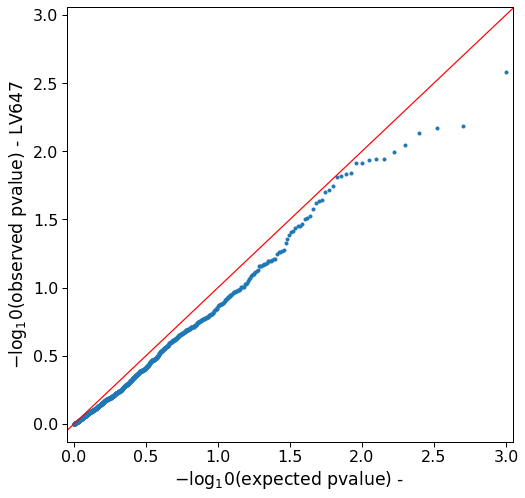

In [125]:
qqplot_unif(results)